<a href="https://colab.research.google.com/github/yanglinjing/dand_p7_data_wragling/blob/master/wrangle_act.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Wrangling - WeRateDogs Twitter 


# Introduction
Real-world data rarely comes clean. Using Python and its libraries, I gathered data from a variety of sources and in 3 different formats, assessed its quality and tidiness, and then cleaned it, which is called data wrangling. 

## Goal
Practice data wrangling using **WeRateDogs Twitter** data in order to create interesting and trustworthy analyses an visualizations. 

## Tools

I documented my wrangling efforts in a Jupyter Notebook, plus showcased them through analyses and visualizations using Python and its libraries (pandas, numpy, requests, json, tweepy, etc.).

## Dataset

My dataset consists of data from 3 different sources. 

### 1. Twitter Archive

The first one is the tweet archive of Twitter user **@dog_rates**, also known as **WeRateDogs**, which is a Twitter account that rates people's dogs with a humorous comment about the dog. 

WeRateDogs has over 4 million followers and has received international media coverage.

Its ratings almost always have a denominator of 10, but the numerators are always greater than 10 (e.g. 11/10, 12/10, 13/10, etc). Why? Because "they're good dogs Brent." 

### 2. Additiona information via the Twitter API

The second one is retweet count and favorite count of each tweet gathered from Twitter's API by Tweetpy Library in a Json format.

### 3.  Image Predictions File
The third is the prediction of dog images and breeds downloaded programtically by Requests Library from the neural network.


## What I did

- Examine the 3 datasets (6,787 total entries)

- Use Python to wrangle and analyze them

- Create a custom visualization to communicate observations

In [0]:
!pip install palettable

    100% |████████████████████████████████| 81kB 3.2MB/s 


In [0]:
import pandas as pd
import requests
import csv
import tweepy
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from palettable.colorbrewer.qualitative import Pastel1_7  # color

% matplotlib inline

In [0]:
# Check current working directory

!pwd

/content


In [0]:
# All the documents are stored on Google Drive.
# It requires authorisation before use them.
# This chunk of code is about authorisation.

# Mounting Google Drive locally
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Change Working Directory in Google Drive

os.chdir('gdrive/My Drive/Colab Notebooks/dand_p7_data_wragling')
!pwd

# Entire Url: '/content/gdrive/My Drive/Colab Notebooks/dand_p7_data_wragling'

/content/gdrive/My Drive/Colab Notebooks/dand_p7_data_wragling


In [0]:
# Create a new folder if it does not exist

folder_name = 'raw_data'
if not os.path.exists(folder_name):
  os.makedirs(folder_name)

In [0]:
my_color = Pastel1_7.hex_colors

In [0]:
# Display full info of df

pd.set_option('display.max_colwidth', -1)

#with pd.option_context('display.max_colwidth', -1): display(df)

# Data Gathering

## Enhanced Twitter Archive
The original data contains basic tweet data for all 5000+ of **WeRateDogs'** tweets, including rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo).

The current dataset is filtered for tweets with ratings only (there are **2356**).
 
However, some of the ratings,  dog names and dog stages probably aren't all correct.
 
Besides, some of the rating numerators are greater than the denominators - this is a unique rating system of WeRateDogs.

No data has been gathered beyond August 1st, 2017.

In [0]:
### 1st df: WeRateDogs Twitter archive

df_1_path = os.path.join(folder_name, 'twitter-archive-enhanced.csv')

with open(df_1_path, 'r') as f:
  df_1 = pd.read_csv(f)

In [0]:
df_1.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [0]:
df_1.shape

(2356, 17)

## Additional Data via the Twitter API
**Retweet count** and **favorite count** are two of the notable column omissions of Twitter archives.

Fortunately, this additional data can be gathered from Twitter's API. 

In [0]:
### 2nd df: 
# Each tweet's retweet count and favorite ("like") count

# Using the tweet IDs in the WeRateDogs Twitter archive, 
# query the Twitter API for each tweet's JSON data 
# using Python's Tweepy library:
# http://www.tweepy.org/

consumer_key = '[consumer_key]'
consumer_secret = '[consumer_secret]'
access_token = '[access_token]'
access_secret = '[access_secret]'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True)
# wait_on_rate_limit = True
# Note: do not include your Twitter API keys, secrets, and tokens

In [0]:
# Use id provided in df_1
# to retrive its retweet & favorite count, and
# temporarily store in a list

df_2_list = []

# Use each id in df_1
for id in df_1['tweet_id']:
  
  try:
    # get status object
    status = api.get_status(id) 

    # get json strings from status obj
    json_str = json.loads(json.dumps(status._json))

    # get retweet/like counts from json strings
    retweet_count = json_str['retweet_count']
    favorite_count = json_str['favorite_count']
    
    # write to list
    df_2_list.append(f"{id} {retweet_count} {favorite_count}")

  # in case there is no status obj returned
  except Exception as e:
    df_2_list.append(f"{id} Nan Nan")


In [0]:
##
# directory of df2

df_2_path = os.path.join(folder_name, 'tweet_json.txt')

In [0]:
# store each tweet's info in a file called tweet_json.txt file. 
# Each tweet's JSON data should be written to its own line. 

with open(df_2_path, "w") as f:
  for item in df_2_list:
    f.write(item + '\n')
    

In [0]:
##
# Read this .txt file line by line into a pandas DataFrame 
# with tweet ID, retweet count, and favorite count. 

df_2 = pd.read_csv(df_2_path,  sep=" ", 
                  names = ['id', 'retweet_count', 'favorite_count'])


In [0]:
df_2.head()

,id,retweet_count,favorite_count
0,892420643555336193,8302,37994
1,892177421306343426,6131,32617
2,891815181378084864,4060,24560
3,891689557279858688,8434,41319
4,891327558926688256,9147,39505


In [0]:
df_2.shape

(2356, 3)

## Image Predictions File

Every image in the WeRateDogs Twitter archive was through a neural network that can classify breeds of dogs.

(The neural network: https://www.youtube.com/watch?v=2-Ol7ZB0MmU)

The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the **most confident prediction** (**numbered 1 to 4** since tweets can have up to four images).

In the table,
- **tweet_id** is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
- **p1** is the algorithm's **#1 prediction** for the image in the tweet → golden retriever
- **p1_conf** is how confident the algorithm is in its #1 prediction → 95%
- **p1_dog** is whether or not the #1 prediction is a breed of dog → TRUE
- **p2** is the algorithm's **2nd most likely prediction** → Labrador retriever
- -etc.

In [0]:
### 3rd df: tweet image predictions

# The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) 
# is present in each tweet according to a neural network. 

# This file (image_predictions.tsv) is hosted on Udacity's servers and 
# should be downloaded programmatically using the Requests library 
# Requests library: http://docs.python-requests.org/en/master/


# Store the content into response in working memory

url_3 = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url_3)

response
# <Response [200]>: success

<Response [200]>

In [0]:
# folder name / file name (shown in url_2):
# 'raw_data/image-predictions.tsv'

df_3_path = os.path.join(folder_name, url_3.split('/')[-1])

In [0]:
# put the content of response into f
with open (df_3_path, mode='wb') as f:
  f.write(response.content)
  
# ensure the new file has been built
# os.listdir(folder_name)

In [0]:
df_3 = pd.read_csv(df_3_path, sep='\t')

df_3.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [0]:
df_3.shape

(2075, 12)

# Data Accessing

## Table 1: Enhanced Twitter Archive

###  Quality issues
Completeness:


-  in_reply_to_status_id: 78 out of 2356 is non-null
- in_reply_to_user_id: 78 out of 2356 is non-null
- retweeted_status_id: 181 out of 2356 is non-null
- retweeted_status_user_id:  181 out of 2356 is non-null
- retweeted_status_timestamp:  181 out of 2356 is non-null
- name: string 'None' should be replaced by Null
- Since only original ratings (no retweets) that have images, the rows of retweets / replys could not contribute to this analysis and should be deleted.
- After retweet / reply rows are deleted, the following columns could be dropped:
 - in_reply_to_status_id
 - in_reply_to_user_id
 - retweeted_status_id
 - retweeted_status_user_id
 - retweeted_status_timestamp


Validity:

- rating_denominator contains invalid values (e.g. denominator = 0, index = 313)
- invalid names like *an, the, only*, etc.

Accuracy:

- rating_numberator contains extremely large values (e.g. 1776 when denominator = 10)
- Since numerators are extracted from 'text', the numerators with decimals were wrongly extracted (index =  45, 340, 695, 763, 1689, 1712)


Data Types:

- tweet_id: int -> obj
-  timestamp: obj -> datetime
-  in_reply_to_status_id: float -> object
- in_reply_to_user_id: float -> object
- retweeted_status_id: float -> object
- retweeted_status_user_id: float -> object

### Tidiness Issues 

- doggo	/ floofer	/ pupper /	puppo: could be combined into 1 column as categorical data.
- source: the long name with HTML tag could be shorten.
 

In [0]:
df_1.info()

# in_reply & retweeted have too much missing values

In [0]:
df_1.sample(3)

In [0]:
df_1.duplicated().sum()

# no duplicated rows

In [0]:
# find retweets

df_1[df_1['retweeted_status_id'].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 19 to 2260
Data columns (total 17 columns):
tweet_id                      181 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     181 non-null object
source                        181 non-null object
text                          181 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 180 non-null object
rating_numerator              181 non-null int64
rating_denominator            181 non-null int64
name                          181 non-null object
doggo                         181 non-null object
floofer                       181 non-null object
pupper                        181 non-null object
puppo                         181 non-null object
dtypes: float64(4), int64(3), object(10)
memor

In [0]:
# find replys

df_1[df_1['in_reply_to_status_id'].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 30 to 2298
Data columns (total 17 columns):
tweet_id                      78 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     78 non-null object
source                        78 non-null object
text                          78 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 23 non-null object
rating_numerator              78 non-null int64
rating_denominator            78 non-null int64
name                          78 non-null object
doggo                         78 non-null object
floofer                       78 non-null object
pupper                        78 non-null object
puppo                         78 non-null object
dtypes: float64(4), int64(3), object(10)
memory usage: 11.0+ KB

In [0]:
df_1['doggo'].value_counts()

In [0]:
df_1['floofer'].value_counts()

In [0]:
df_1['pupper'].value_counts()

In [0]:
df_1['puppo'].value_counts()

In [0]:
df_1['rating_denominator'].value_counts()

In [0]:
df_1[df_1['rating_denominator'] !=10]

# index = 313 (denominator = 0) should be deleted.

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,http...",9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,http...",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitte

In [0]:
df_1.query('rating_denominator == 10')['rating_numerator'].describe()

# check the data max = 1776
# min = 0 is correct

count    2333.000000
mean       12.237462
std        41.022472
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [0]:
df_1.query('rating_denominator == 10').sort_values('rating_numerator', ascending=False)

# some numerators are extremely large: 75 - 1776

In [0]:
# The rating_numerator column should of type float and 
# also it should be correctly extracted. 
# On assessing the twitter_enhanced.csv file 
# you will see on row 46 that the correct rating 
# in the tweet is 13.5 but it's extracted as 5. 
# There are many more such rows in the dataset. 
# So it should be extracted and cleaned correctly.
# e.g 13.5/10 --> 5/10

# find decimal ratings
df_1[df_1.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

# The following rows got wrong numerator
# index = [45, 340, 695, 763, 1689, 1712]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,text,rating_numerator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1689,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26


In [0]:
df_1['source'].value_counts()

# <a> tag could be deleted

In [0]:
df_1.sample(3)['expanded_urls']


2152                                                                                                                                            https://twitter.com/dog_rates/status/669680153564442624/photo/1
762     https://twitter.com/dog_rates/status/778039087836069888/photo/1,https://twitter.com/dog_rates/status/778039087836069888/photo/1,https://twitter.com/dog_rates/status/778039087836069888/photo/1,http...
1313                                                                                                                                                                              https://vine.co/v/iXQAm5Lrgrh
Name: expanded_urls, dtype: object

In [0]:
# invalid names 
# like 'an, the, only', etc.
# they all start with lowercase characters. 
# correct names for these tweets start with upper case letter and 
# are generally after the word 'is, named', etc.

df_1['name'].value_counts()

## Table 2: Additional Infomation (Retweet & Favourate)

### Quality issues

Completeness:

- retweet & favourite  count: "Nan" should be replaced by Null.
- retweet & favourite  count: 16 missing values

Data Type:
 - retweet & favourite  count: obj -> int

In [0]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
id                2356 non-null int64
retweet_count     2356 non-null object
favorite_count    2356 non-null object
dtypes: int64(1), object(2)
memory usage: 55.3+ KB


## Table 3: Image Predictions

### Quality Issues

Consistency: 
- The predicted names are written in both upper and lower cases.


Data Types:

- tweet_id: int -> obj

The column names could be more clear.

In [0]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [0]:
df_3.sample(3)

In [0]:
df_3.duplicated().sum()

In [0]:
df_3['p1'].value_counts()

In [0]:
df_3['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

# Data Cleaning


## Table 1

In [0]:
# Make Copies

# Note: df_1_copy = df_1 does NOT makes copies of the dataset, 
# just creates a new variable pointing to same location.

# Use the copy() function to make copies 

df_1_copy = df_1.copy()
df_2_copy = df_2.copy()
df_3_copy = df_3.copy()

### Issue #1 Deleting Retweet Rows

#### Define

- Since only original ratings (no retweets) that have images, the rows of retweets could not contribute to this analysis and should be deleted.

#### Clean

In [0]:
# find retweets

df_retweets = df_1_copy[df_1_copy['retweeted_status_id'].notnull()]

In [0]:
# Drop retweet rows

df_1_copy.drop(df_retweets.index, inplace=True)

#### Test

In [0]:
df_1_copy.info()

### Issue #2 Deleting Reply Rows

#### Define

- Since only original ratings (no retweets) that have images, the rows of replys could not contribute to this analysis and should be deleted.

#### Clean

In [0]:
# find replys

df_replys = df_1_copy[df_1_copy['in_reply_to_status_id'].notnull()]

In [0]:
# drop replys
df_1_copy.drop(df_replys.index, inplace = True)

#### Test

In [0]:
df_1_copy.info()

### Issue #3 Deleting Retweet / Replys Columns

#### Define

- After retweet / reply rows are deleted, the following columns are empty and could be dropped:
 - in_reply_to_status_id
 - in_reply_to_user_id
 - retweeted_status_id
 - retweeted_status_user_id
 - retweeted_status_timestamp

#### Clean

In [0]:
df_1_copy = df_1_copy.drop(columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'])

#### Test

In [0]:
df_1_copy.info()

### Issue #4 Dog Stages

#### Define

- doggo / floofer / pupper / puppo: could be combined into 1 column as categorical data.

#### Clean

In [0]:
# combine into 1 column

dog_stages = ['doggo', 'floofer', 'pupper', 'puppo']

for i, row in df_1_copy.iterrows():
    ifor_val = ''
    for dog_stage in dog_stages:
      if row[dog_stage] != 'None':
        ifor_val += dog_stage
    df_1_copy.at[i,'stage'] = ifor_val

In [0]:
# drop the original 4 columns

df_1_copy.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], 
               inplace = True)

A new quality issue rises:

- a few dogs have been marked in 2 stages.

In [0]:
df_1_copy.replace(
    {'stage': {
        '': np.NaN,
        'doggopupper': 'doggo, pupper',
        'doggopuppo': 'doggo, puppo',
        'doggofloofer': 'doggo, floofer'
    }}, 
    inplace = True)

#### Test

In [0]:
df_1_copy['stage'].value_counts()

# a few dogs were marked as in 2 stages.

pupper           221
doggo             72
puppo             23
floofer            9
doggo, pupper      9
doggo,floofer      1
doggo,puppo        1
Name: stage, dtype: int64

### Issue #5 Source

#### Define

- In the column of source, the long name with HTML tag could be shorten.

#### Clean

In [0]:
df_1_copy.replace({'source': {
    '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'Twitter for iPhone',
    '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>': 'Vine',
    '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Twitter Web Client',
    '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'TweetDeck'
}}, inplace = True)

#### Test

In [0]:
df_1_copy.sample(3)

### Issue #6 Rating Denominator

#### Define

rating_denominator contains invalid values (e.g. denominator = 0, index = 313)

#### Clean
It has already been dropped in the steps above.

#### Test

In [0]:
df_1_copy.query('rating_denominator == 0')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage


### Issue #7 Rating Numerator - Correcting Values

#### Define

- Since numerators are extracted from 'text', the numerators with decimals were wrongly extracted (index =  45, 340, 695, 763, 1689, 1712)

#### Clean

In [0]:
# Check whether they have already been deleted

df_1_copy[df_1_copy.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,text,rating_numerator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26


In [0]:
numerator_indexes = [45, 695, 763, 1712]

numerators = [13.5, 9.75, 11.27, 11.26]

for i in range(len(numerator_indexes)):
  df_1_copy.loc[numerator_indexes[i], 'rating_numerator'] = numerators[i]


#### Test

In [0]:
df_1_copy[df_1_copy.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,text,rating_numerator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26


### Issue #8 Rating Numerator - Outliers

#### Define

- rating_numerator contains extremely large values (e.g. 1776 when denominator = 10)

#### Clean

In [0]:
df_1_copy['ratings'] = df_1_copy['rating_numerator'] / df_1_copy['rating_denominator']

In [0]:
df_1_copy['ratings'].describe()

In [0]:
outliers = df_1_copy.query('ratings >2')
outliers

In [0]:
df_1_copy.drop(outliers.index, inplace = True)

#### Test

In [0]:
df_1_copy.query('ratings >2')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,ratings


### Other Issues
- Name Column is not cleaned as it is not related to analysis in this report.
- Data type issues (other than tweet_id) will be cleaned at the last step of data cleaning.

## Table 2

### Issue #1 Missing Values

#### Define

- Replace missing values by Null.

#### Clean



In [0]:
# Replace str 'Nan' with Null

df_2_copy.replace('Nan', np.NaN, inplace = True)

#### Test

In [0]:
df_2_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
id                2356 non-null int64
retweet_count     2340 non-null object
favorite_count    2340 non-null object
dtypes: int64(1), object(2)
memory usage: 55.3+ KB


## Table 3

### Issue #1 Missing Values

#### Define

- Rename Columns.

#### Clean

In [0]:
df_3_copy.rename(columns = {
    'p1': 'predict_1',
    'p1_dog': 'p1_breed_dog',
    'p2': 'predict_2',
    'p2_dog': 'p2_breed_dog',
    'p3': 'predict_3',
    'p3_dog': 'p3_breed_dog',
    'tweet_id': 'tweet_id_3'
}, inplace = True)

#### Test

In [0]:
df_3_copy.sample(3)

,tweet_id_3,jpg_url,img_num,predict_1,p1_conf,p1_breed_dog,predict_2,p2_conf,p2_breed_dog,predict_3,p3_conf,p3_breed_dog
1140,729823566028484608,https://pbs.twimg.com/media/CiDap8fWEAAC4iW.jpg,1,kelpie,0.218408,True,arabian_camel,0.114368,False,coyote,0.096409,False
1786,829449946868879360,https://pbs.twimg.com/media/C4LMUf8WYAkWz4I.jpg,1,labrador_retriever,0.315163,True,golden_retriever,0.153210,True,pekinese,0.132791,True
102,667801013445750784,https://pbs.twimg.com/media/CUSBemVUEAAn-6V.jpg,1,flat-coated_retriever,0.508392,True,chesapeake_bay_retriever,0.262239,True,curly-coated_retriever,0.048920,True


### Issue #2 Name Consistency

#### Define

- Change the prediction name to lower case.

#### Clean

In [0]:
cols = ['predict_1', 'predict_2', 'predict_3']

for col in cols:
  df_3_copy[col] = df_3_copy[col].str.lower()

#### Test

In [0]:
df_3_copy.sample(3)

## Joint Table

### Issue # 1 Combining 3 Tables

#### Define
- Combine 3 tables together (left join df_1_copy).

#### Clean

In [0]:
df_joint = pd.merge(df_1_copy,
                   df_2_copy,
                   left_on = 'tweet_id',
                   right_on = 'id',
                   how = 'left'
                   )

In [0]:
df_joint = pd.merge(df_joint,
                   df_3_copy,
                   left_on = 'tweet_id',
                   right_on = 'tweet_id_3',
                   how = 'left'
                   )

In [0]:
df_joint.drop(columns={'id', 'tweet_id_3'}, inplace = True)

#### Test

In [0]:
df_joint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 23 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null object
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2091 non-null object
rating_numerator      2094 non-null float64
rating_denominator    2094 non-null int64
name                  2094 non-null object
stage                 336 non-null object
ratings               2094 non-null float64
retweet_count         2092 non-null object
favorite_count        2092 non-null object
jpg_url               1968 non-null object
img_num               1968 non-null float64
predict_1             1968 non-null object
p1_conf               1968 non-null float64
p1_breed_dog          1968 non-null object
predict_2             1968 non-null object
p2_conf               1968 non-null float64
p2_breed_dog          1968 non-null object
predict_3             1968 non-

In [0]:
df_joint.sample(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,ratings,...,img_num,predict_1,p1_conf,p1_breed_dog,predict_2,p2_conf,p2_breed_dog,predict_3,p3_conf,p3_breed_dog
1625,675147105808306176,2015-12-11 02:56:28 +0000,Twitter for iPhone,When you're presenting a group project and the 4th guy tells the teacher that he did all the work. 10/10 https://t.co/f50mbB4UWS,https://twitter.com/dog_rates/status/675147105808306176/photo/1,10.0,10,None,NaN,1.0,...,1.0,golden_retriever,0.949215,True,labrador_retriever,0.016765,True,flat-coated_retriever,0.010637,True
1984,667902449697558528,2015-11-21 03:08:47 +0000,Twitter for iPhone,This is Cleopatricia. She is a northern Paperback Maple. Set up hammock somehow. 9/10 would chill in hammock with https://t.co/sJeHdGUt0W,https://twitter.com/dog_rates/status/667902449697558528/photo/1,9.0,10,Cleopatricia,NaN,0.9,...,1.0,norwegian_elkhound,0.298881,True,malamute,0.279479,True,eskimo_dog,0.198428,True


### Issue # 2 Reorder Columns

#### Define
- Move the useless columns (e.g. url) to the end.

#### Clean

In [0]:
# get column names

cols = df_joint.columns.tolist()


In [0]:
# reorder column names

cols = ['tweet_id',
        'timestamp',
        'ratings',
        'retweet_count',
        'favorite_count',
        'source',
        'stage',        
        'name',
        'predict_1',
        'p1_conf',
        'p1_breed_dog',
        'text',
        'predict_2',
        'p2_conf',
        'p2_breed_dog',
        'predict_3',
        'p3_conf',
        'p3_breed_dog',
        'rating_numerator',
        'rating_denominator',
        'jpg_url',
        'img_num',
        'expanded_urls']


23

In [0]:
# reorder columns

df_joint = df_joint[cols]

#### Test

In [0]:
df_joint.sample(2)

,tweet_id,timestamp,ratings,retweet_count,favorite_count,source,stage,name,predict_1,p1_conf,...,p2_conf,p2_breed_dog,predict_3,p3_conf,p3_breed_dog,rating_numerator,rating_denominator,jpg_url,img_num,expanded_urls
283,829449946868879360,2017-02-08 22:00:52 +0000,1.1,2191,11023,Twitter for iPhone,doggo,None,labrador_retriever,0.315163,...,0.153210,True,pekinese,0.132791,True,11.0,10,https://pbs.twimg.com/media/C4LMUf8WYAkWz4I.jpg,1.0,https://twitter.com/dog_rates/status/829449946868879360/photo/1
836,742465774154047488,2016-06-13 21:16:49 +0000,1.4,4149,7594,Twitter for iPhone,pupper,None,web_site,0.997154,...,0.000439,False,desktop_computer,0.000268,False,14.0,10,https://pbs.twimg.com/media/Ck3EribXEAAPhZn.jpg,1.0,"https://twitter.com/dog_rates/status/742465774154047488/photo/1,https://twitter.com/dog_rates/status/742465774154047488/photo/1"


## Write to CSV File

In [0]:
# write to csv file

df_joint.to_csv('twitter_archive_master.csv', 
                index = False)


## Change Data Type

In [0]:
df = pd.read_csv('twitter_archive_master.csv')

In [0]:
df.info()

- timestamp: obj -> datetime

In [0]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

- img_num / retweet_count / favorite_count: float -> int

In [0]:
cols = ['img_num', 'retweet_count', 'favorite_count']

df[cols] = df[cols].fillna(0.0).astype(int)

# Analysing Data

## 1. Dog Ratings

Since there are various rating denominators (although most of them are 10), the rating of dogs is calculated by dividing the numerator by the denominator.

The outliers have been deleted in Data Cleaning section.

It shows that the ratings of dogs are left-skewed distributed, with the mean of 1.06 and the median of 1.10. Besides, 25% of the dogs are rated equal to or more than 100%. Thus, it can be found that most dogs are considered to be better than perfect.

In [0]:
df['ratings'].describe()

count    2094.000000
mean        1.060283
std         0.215734
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max         1.400000
Name: ratings, dtype: float64

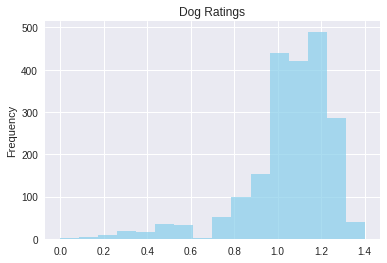

In [0]:
# draw

df['ratings'].plot(kind = 'hist',
                  color = 'skyblue',
                  alpha = 0.7,
                  bins = 16,
                  title = 'Dog Ratings')

## 2. Source of Tweet

From the pie chart, it presents that the dominate source is from iPhone, which is 93.7%. Only a few people use Vine (4.3%), Website (1.5%) and TweetDect (0.5%) to browse WeRateDogs Tweet.

In [0]:
df["source"].value_counts()

Twitter for iPhone    1962
Vine                    91
Twitter Web Client      31
TweetDeck               10
Name: source, dtype: int64

In [0]:
# set labels & values for pie

pie_names = ['Twitter for iPhone',
             'Twitter Web Client',
             'Vine',
             'TweetDeck' ]

pie_size = []

for pie_name in pie_names:
  size = df.query('source == @pie_name')['source'].count()
  pie_size.append(size)
  

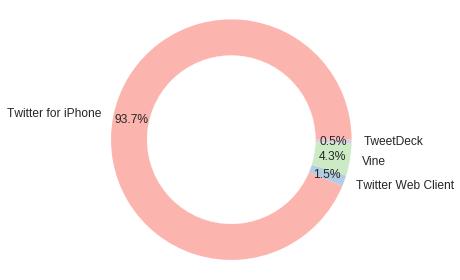

In [0]:
# draw pie chart

fig1, ax1 = plt.subplots()

ax1.pie(pie_size, 
        labels = pie_names, 
        colors = my_color, 
        textprops = {'fontsize': 12},
        autopct = '%1.1f%%',
        pctdistance = 0.85)

# draw circle
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)


# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()


## 3. **Relationship between** Retweet and Favourite

The count of retweet and favourite are highly positively correlated ( *r * = 0.927). Thus, we could say that the more people like a tweet, the more they retweet it.

Text(0.5, 1.0, 'Retweet v.s. Favourite')

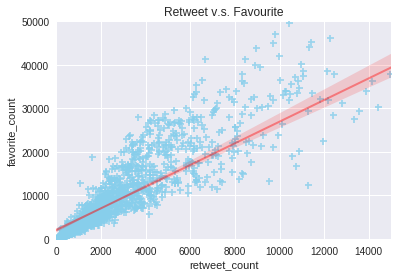

In [0]:
# draw scatter plot

sns.regplot(x=df["retweet_count"], 
            y=df["favorite_count"], 
            line_kws={"color":"r","alpha":0.4,"lw":2},
            marker="+",
            color = 'skyblue')

# control x and y limits
sns.plt.ylim(0, 50000)
sns.plt.xlim(0, 15000)
sns.plt.title('Retweet v.s. Favourite')

#sns.plt.show()

In [0]:
df[['retweet_count', 'favorite_count']].corr()

,retweet_count,favorite_count
retweet_count,1.000000,0.927176
favorite_count,0.927176,1.000000


## 4. Breeds

The top 15 predicted dogs are shown in the plot.

It can be seen that **Golden Retriever** is the No.1 predicted dog, which has been predicted 150 times with high confidence. The confidence of predicting it is left skewed, with the median of 0.78 and mean of 0.72.

The second most predicted dog is **Labrador Retriever** (100 times), the high confidence of which is also left skewed with the median of 0.71 and mean of 0.67.

In [0]:
# Store value_counts and dog_types into df_predict
df_predict = df['predict_1'].value_counts().to_frame()

# rename columns of df_predict
df_predict.rename(columns = {'predict_1': 'counts'}, inplace = True)

# only keep dogs that appear 20+ 
df_predict = df_predict.query('counts > 20')

# Reorder it following the values:
df_predict = df_predict.sort_values(by = 'counts')

# set range
my_range = range(1, df_predict.shape[0] + 1)

Text(0, 0.5, 'Dog Types')

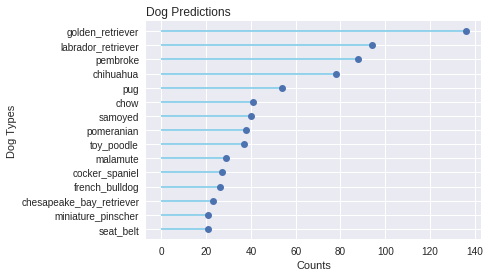

In [0]:
# Draw lolipop plot

plt.hlines(y=my_range, xmin=0, xmax=df_predict['counts'], color='skyblue')
plt.plot(df_predict['counts'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, df_predict.index)

plt.title("Dog Predictions", loc='left')
plt.xlabel('Counts')
plt.ylabel('Dog Types')


In [0]:
golden_retriever = df.query('predict_1 == "golden_retriever"')['p1_conf']

golden_retriever.describe()

count    136.000000
mean       0.727063
std        0.219720
min        0.140394
25%        0.607729
50%        0.777851
75%        0.904843
max        0.993830
Name: p1_conf, dtype: float64

In [0]:
labrador_retriever = df.query('predict_1 == "labrador_retriever"')['p1_conf']

labrador_retriever.describe()

count    94.000000
mean      0.656606
std       0.236406
min       0.195835
25%       0.459328
50%       0.700055
75%       0.866493
max       0.999885
Name: p1_conf, dtype: float64

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


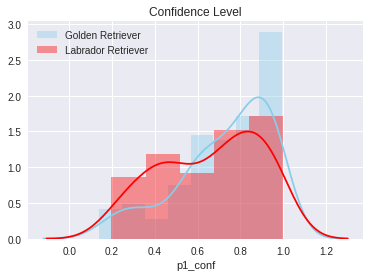

In [0]:
sns.distplot(golden_retriever , color="skyblue", label="Golden Retriever")
sns.distplot(labrador_retriever , color="red", label="Labrador Retriever")

sns.plt.title('Confidence Level')

sns.plt.legend()

## 5. Dog Stages

Only 336 out of 2094 dogs have their stages presented in the dataset. The most common stage is pupper (230), followed by doggo (83) among the dogs whose stage has been presented.

In [0]:
# check dog stages

df_stage = df['stage'].value_counts().to_frame()
df_stage.rename(columns = {'stage': 'counts'}, inplace = True)
df_stage

In [0]:
# store all stages into a list
stages_all = df_stage.index.tolist()

In [0]:
# new dict (for new df)

dict_stages = {'pupper': 0, 
            'doggo': 0, 
            'puppo': 0, 
            'floofer': 0}

In [0]:
# fill num to new dict

for stage in stages_all:
  
  # get num in original df_stage
  n = df_stage.loc[stage, 'counts']
  
  # e.g: if 'pupper' in 'doggo, pupper'
  for k,v in dict_stages.items():
    if k in stage:
      dict_stages[k] += n
      
dict_stages

{'doggo': 83, 'floofer': 10, 'pupper': 230, 'puppo': 24}

In [0]:
stages = pd.DataFrame(list(dict_stages.items()), columns = ['stage', 'counts'])
stages.sort_values(by = ['counts'])

,stage,counts
3,floofer,10
2,puppo,24
1,doggo,83
0,pupper,230


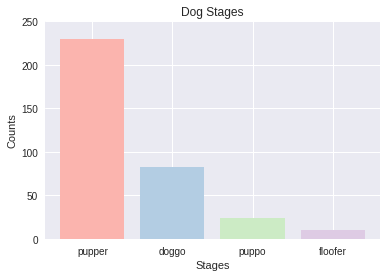

In [0]:
# Create bars and choose color
plt.bar(stages['stage'], stages['counts'], color = my_color)
 
# Limits for the Y axis
plt.ylim(0,250)

# Add title and axis names
plt.title('Dog Stages')
plt.xlabel('Stages')
plt.ylabel('Counts')
 
# Show graphic
plt.show()


## 6. Post Tweet Day

From Monday to Sunday, the number of posted tweet decreases. WeRateDogs followers may expect to see more new tweets on Monday.

In [0]:
df['weekday'] = df['timestamp'].dt.dayofweek

In [0]:
df['weekday'].value_counts()
# Monday=0, Sunday=6

0    350
1    312
2    310
3    295
4    292
5    268
6    267
Name: weekday, dtype: int64

In [0]:
weekdays = df['weekday'].value_counts().to_frame()

weekdays.rename(columns = {'weekday': 'Counts'}, inplace = True)

weekdays['Weekday'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']

#weekdays.set_index('Weekday', inplace = True)
weekdays

,Counts,Weekday
0,350,Monday
1,312,Tuesday
2,310,Wednesday
3,295,Thursday
4,292,Friday
5,268,Saturday
6,267,Sunday


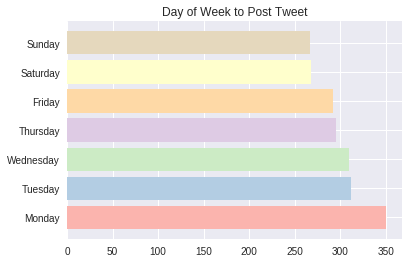

In [0]:
# draw

y_pos = np.arange(weekdays['Weekday'].count())
 
# Create horizontal bars
plt.barh(y_pos, weekdays['Counts'], color=my_color)
 
# Create names on the y-axis
plt.yticks(y_pos, weekdays['Weekday'])
 
# Show graphic
plt.title('Day of Week to Post Tweet')
plt.show()


# Conclusion

1. 25% of the dogs are rated equal to or more than 100%. Thus, most dogs are considered to be better than perfect.
- The dominant source is from iPhone (93.7%).
- The count of retweet and favourite are highly positively correlated - the more people like a tweet, the more they retweet it.
- The top 1 predicted dog is golden retriever, followed by labrador retriever.
- The most common stage is pupper, followed by doggo.
- From Monday to Sunday, the number of posted tweet decreases. 
